# Co-Kriging

While ordinary kriging considered autocorrelation of one variable to predict values of unknown set of points, CoKriging includes cross-correlation with other variables for prediction. The CoKriging method is commonly used in instances where the sample size of the primary variable is small and/or it is expensive to collect a large sample. Therefore, other variables which are highly correlated with primary variable and more easily sampled are used to enhance prediction. 

In this practice, the cokriging interpolation method is conducted using gstat library: https://cran.r-project.org/web/packages/gstat/gstat.pdf

In [1]:
inLibraries = list('repr','rgdal','rgeos','gstat','spdep','car','classInt','forecast','Hmisc','RColorBrewer')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Read Observed Measurements

In this practice, the primary goal is to obtain a good estimate of water well depth for locations in Missouri. While observations of well depth from locations surrounding the state would be better, here we will proceed with only observations from within the state. Thus, we will need to wary of edge effects.  

The observation well locations can be found at (mo_counties/well_obs.shp) and state boundaries that can be used for spatial context can be found at (mo_counties/countiesMO.shp). Metadata for the observation well dataset can be found at: ftp://msdis.missouri.edu/pub/metadata_gos/MO_2013_Groundwater_Observation_Wells_shp.xml

In this practice, the primary variable to interpolate will be total well depth 'TOTDEPTH' and the secondary variable used to support the interpolation will be elevation 'ELEVATION'.

In [2]:
# Read point data
inFeature.pts <- readOGR("/dsa/data/geospatial/DS8612/mo_counties","well_obs")

# Read polygon boundary data
inFeature.poly <- readOGR("/dsa/data/geospatial/DS8612/mo_counties","countiesMO")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/mo_counties", layer: "well_obs"
with 171 features
It has 26 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/mo_counties", layer: "countiesMO"
with 115 features
It has 48 fields


## Visualize the Observed Data Points

Classify the observed depth values 'TOTDEPTH' and plot the points to examine the spatial distribution of the weather data.

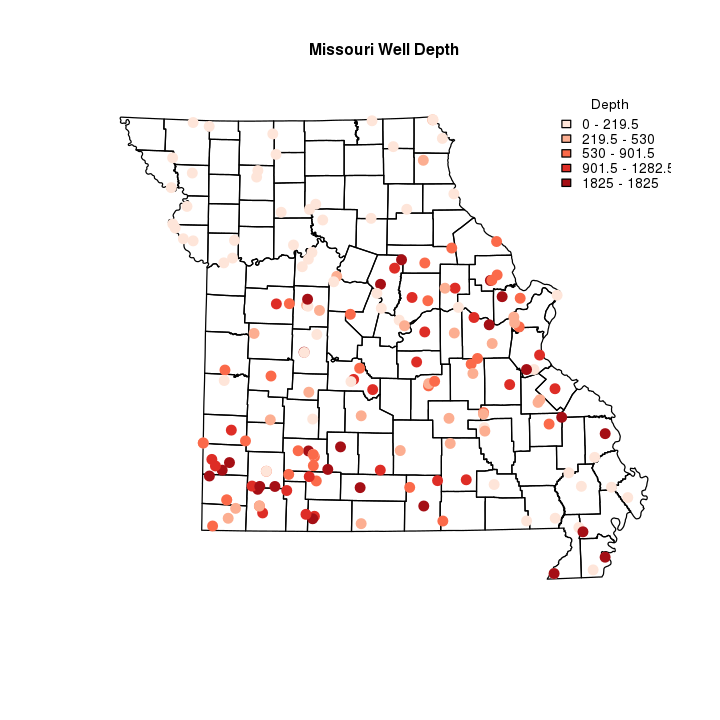

In [3]:
inValue <- as.numeric (inFeature.pts@data$TOTDEPTH)

# Define number of classes and classification method
numcat <- 5
cate <- classIntervals(inValue, numcat, style="kmeans")

# Define number of color symbols
pal <- brewer.pal(numcat,"Reds")
# Match color symbols with class intervals
cols <- findColours(cate,pal)

# Plot the state boundary
plot(inFeature.poly,main="Missouri Well Depth",cex.main=.8)
# Plot the point feature
plot(inFeature.pts, col=cols, pch=20, lwd=4,add=TRUE)

# Create the legend object
#map classification scheme
decimalPlaces <- 3
brks.dec <- round(cate$brks,decimalPlaces)
leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep=" - ")
legend("topright",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Depth",cex=.7)

## Subset Data

There are an array of issues that can arise when working with geographic data. For example, sometimes more than one sample can be present at the identical location, the data can misrepresent the regional phenonmena, or the attribution of the data can be incorrect or such that the distributional characteristics of the data are severely affected. 

In this dataset, there are some wells with a reported depth of zero as well as some that are shallow given they were created in specific conditions at some point in history...both of which would severely skew the data if included. So, let's not select them for subseqent analysis and only include wells with depths greater than 1' Also, there are some well records that are reported at exactly the same geographic location (x,y coordinates are the same). In those cases, we should only retain one record for each site.

In [4]:
#select subset of well data to use
#a) select only wells with a depth greater than 1'
subFeature.pts <- inFeature.pts[inFeature.pts@data$TOTDEPTH>=1,]
length(subFeature.pts)

#b) select well locatations that are at unique sites (i.e. if two or more exist at one location, only select one)
subFeature.pts2 <- subFeature.pts[-zerodist(subFeature.pts)[,1],] 
length(subFeature.pts2)

[1] 167

[1] 161

### Evaluate Geographic Distribution

Note that in the map shown earlier, something is up with the northern portion of the state...wells are much shallower! This geographic trend is rather clear. As such, it indicates that depth in this application may vary regionally and that it could be a bad idea to interpolate the entire region at once. Why? Given the geographic trends exhibited here, the distribution would likely be heavily biased to the left (low values of depth). Let's try interpolation for the southern portion of the state where there is more heterogenity in depth.

To do this, there is a field in the county dataset named 'NorthernMo' which = 1 for counties classified as northern and 0 for all other counties. Given this, let's select counties in the south, union them together and select well sites that occur in the southern portion of the state.

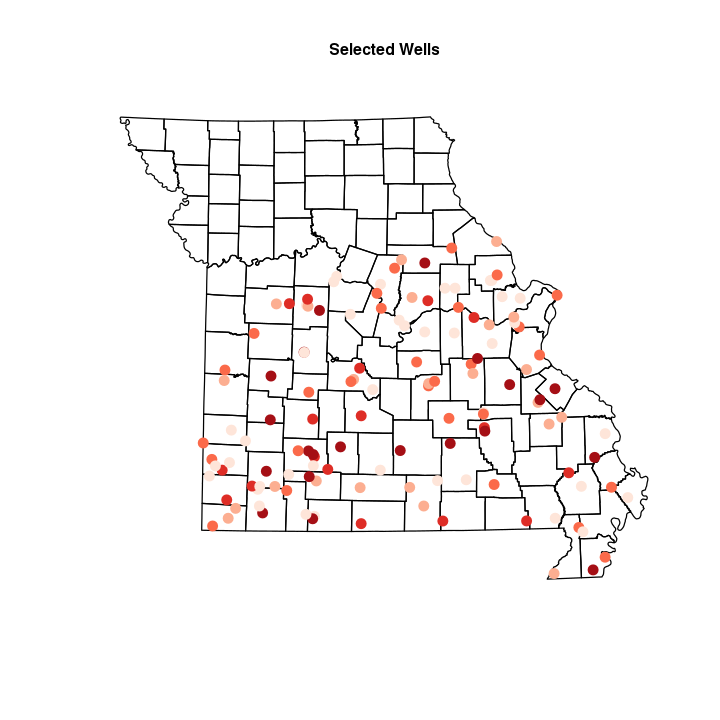

In [6]:
#select counties only in southern portion of state
SouthernMO <- inFeature.poly[inFeature.poly@data$NorthernMo == 0,]

#union selected counties
SouthernMO.union <- gUnaryUnion(SouthernMO)

#Identify features that INTERSECT the selected feature
##See documentation of rgeos:: over() function
selWells <- overGeomGeom(SouthernMO.union,subFeature.pts2,returnList = TRUE, fn = NULL)

#unlist the list
intSet <- unlist(selWells)

#Select the intersecting features from the featureclass
intWells <- subFeature.pts2[intSet,]

# Plot the state boundary
plot(inFeature.poly,main="Selected Wells",cex.main=.8)
# Plot the point feature
plot(intWells, col=cols, pch=20, lwd=4,add=TRUE)

## Retrieve Analysis Variables

Here we will work with well depth 'TOTDEPTH' and elevation of the landscape 'ELEVATION' for the selected wells.

In [7]:
#extract analysis variables (totdepth and elevation)
inVa1 <- as.numeric (intWells@data$TOTDEPTH)
inVa2 <- as.numeric (intWells@data$ELEVATION)

## Test for Normality (primary variable)

First, test the primary variable 'TOTDEPTH' for normality.  If it is not normal enough, attempt an appropriate transformation. Here a box-cox transformation is applied to get the variable into a closer to normal distribution. While the distributional characteristics improve slightly, they are still far from desirable. Perhaps you can figure out a better transformation and/or method for adjusting the data?


	Shapiro-Wilk normality test

data:  inVa1
W = 0.95341, p-value = 0.0002221


[1] 0.55

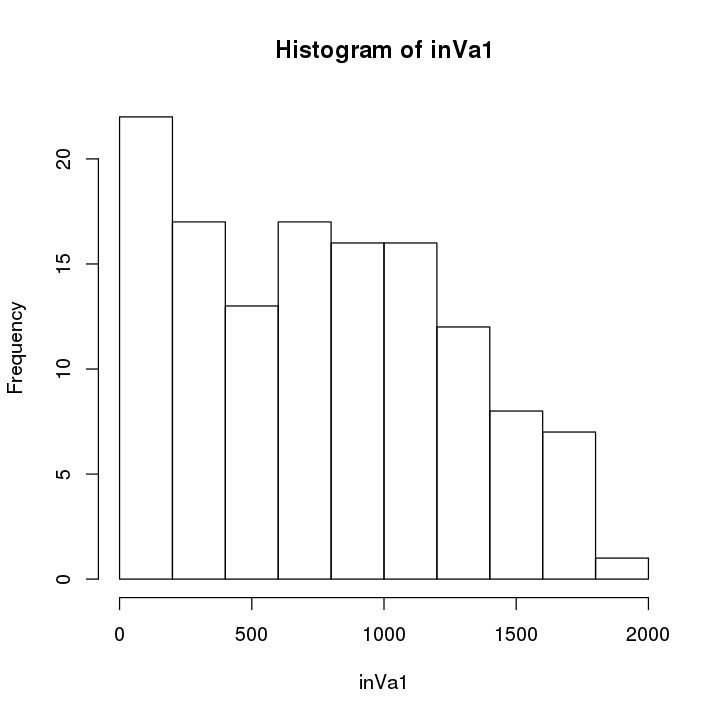


	Shapiro-Wilk normality test

data:  tv1
W = 0.96385, p-value = 0.001632


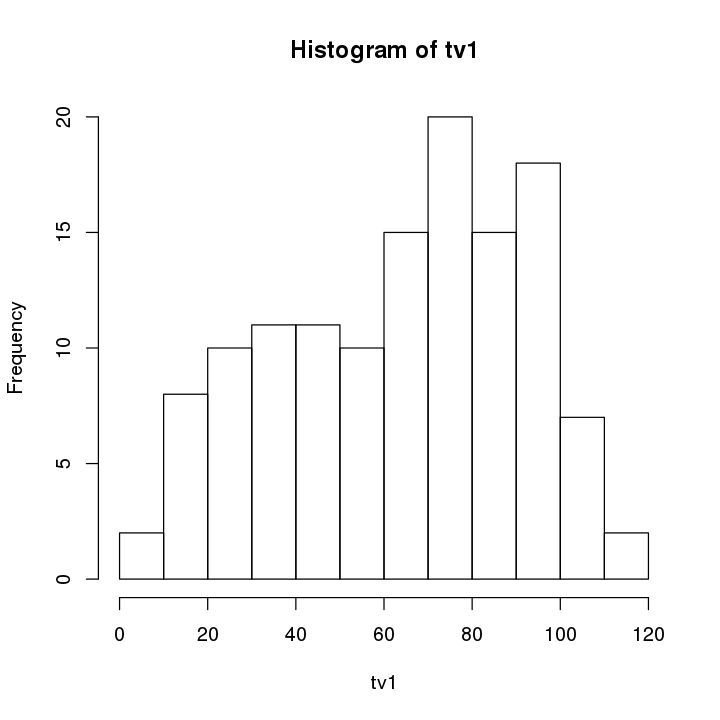

In [8]:
#test variable distribution
shapiro.test(inVa1)
hist(inVa1)

#box-cox transformation
lambda <- BoxCox.lambda(inVa1,method = "loglik",lower=-4,upper=4) 
lambda

#apply box cox transformation to variable
tv1 <- BoxCox(inVa1,lambda)

#test transformed variable
hist(tv1)
shapiro.test(tv1)

#add a new variable to the dataframe to represent the transformed variable
intWells$depthT <- tv1

## Test for Normality (the co-variable)

Now test the second variable 'ELEVATION' for normality.  If it is not normal enough, attempt an appropriate transformation. In this example, the test indicates normality, so no transformations are made. However, experiment on your own and see if a better tranformation can be found.


	Shapiro-Wilk normality test

data:  inVa2
W = 0.97873, p-value = 0.04018


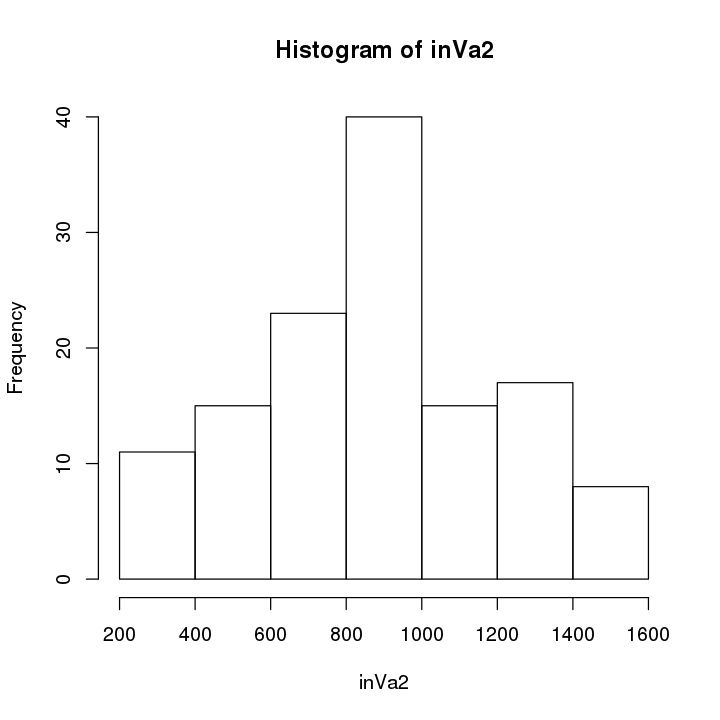

In [9]:
#test variable for normality
shapiro.test(inVa2)
hist(inVa2)

#tranfer the variable
tv2 <- inVa2

#add a new variable to the dataframe to represent the transformed variable
intWells$elevationT <- tv2

# Assess Correlation among Variables

The pearson correlation between the transformed primary (depth) and co-variable (elevation) is calculated using rcorr() function (Hmisc library). As can be seen, the r value is 0.31 and p-value is 0.00. 

In [10]:
# Find pearson correlation between main and co-variable
Pcor <- rcorr (cbind(tv1,tv2),type="pearson")
Pcor

     tv1  tv2
tv1 1.00 0.31
tv2 0.31 1.00

n= 129 


P
    tv1   tv2  
tv1       4e-04
tv2 4e-04      

## Create a Grid Dataframe

The CoKrige function (gstat library) requires an input grid dataframe to which to interpolate the point values. In order to create a grid that covers the study area, the extent of data should be specified. Also, the grid projection needs to be the same as input data. In other practices, the extend.grid() function is used. Here, the spsample() function (sp library) is used to generate a certain number of regularlly spaced points within the study area extent. Then, the SpatialPixels() function (sp library) is used to create a grid dataframe based on the point locations.

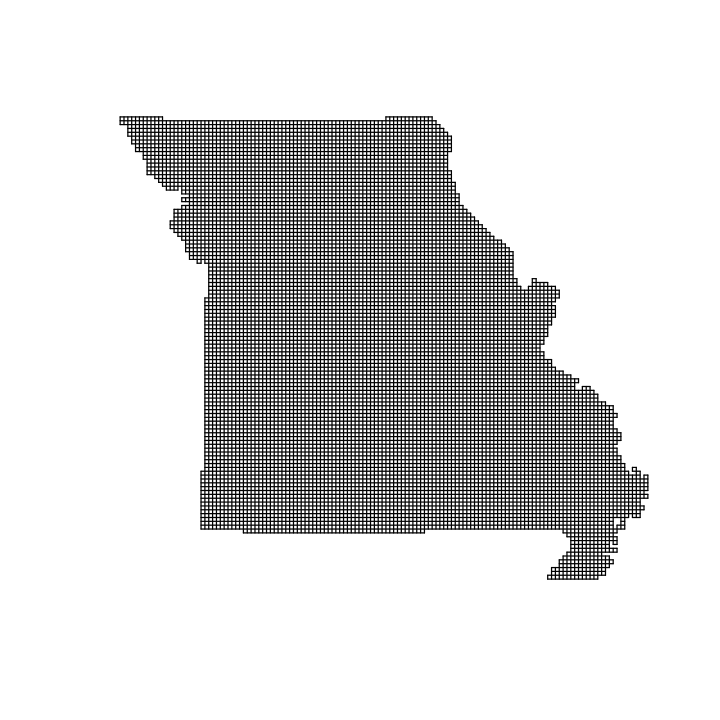

In [12]:
#conduct a regular sample of study extent
numsamples <- 10000
Reg <- spsample(inFeature.poly, numsamples, type="regular")

#create grid dataframe
Reg.grid <- SpatialPixels(Reg)
proj4string(Reg.grid) <- proj4string(inFeature.pts)

#plot grid dataframe
plot(Reg.grid)

## Empirical variograms

When co-kriging based on two variables, three variograms should be created. A direct variograms for the primary variable and the co-variable and a cross variogram of both variables. A "gstat" object (gstat library) is used to hold all the information necessary for analysis. Once variables are added to the gstat object, empirical variograms can then be generated via the variogram() function (gstat library).

NOTE: Just as with the IDW implementation in gstat, the number of neighbors for which the interpolation of each cell is based can be controlled by adding a 'nmin' and/or 'nmax' argument to the gstat() function(s). By default, interpolation of any cell will involve ALL sample points.

More documentations on Cokriging method and variograms can be found at: http://spatial-analyst.net/ILWIS/htm/ilwisapp/cokriging_functionality.htm

In [14]:
# Create a gstat object and add main variable
ck.g  <- gstat(NULL, "depth", depthT ~ 1, intWells,set = list(nocheck = 1))

# Add covariable to gstat object
ck.g  <- gstat(ck.g, "elev", elevationT ~ 1, intWells)

# Create empirical variogram
ck.v <- variogram(ck.g)

### Evaluate variograms

By generating variograms from the gstat object, 

a table containing the variograms: 

a) depth, 

b) elevation, and 

c) depth&elevation can be accessed after ck.v is built. 

In this table, np is number of points used to make the estimation, dist is average distance of all point pairs considered for estimation, gamma is the actual variogram estimate and id is used to label the different variograms.

In [15]:
#display created variograms
ck.v

np,dist,gamma,dir.hor,dir.ver,id
90,7680.289,193.4551,0,0,depth.elev
166,20163.025,787.9403,0,0,depth.elev
338,34002.201,755.6494,0,0,depth.elev
426,46758.326,388.5419,0,0,depth.elev
550,59595.246,848.5375,0,0,depth.elev
604,72405.282,975.9841,0,0,depth.elev
600,85870.191,1314.3275,0,0,depth.elev
636,99133.724,987.7758,0,0,depth.elev
718,112647.557,1685.4200,0,0,depth.elev
694,125193.293,2381.2807,0,0,depth.elev


### Empirical Variograms

Now, compute the empirical variograms using the fit.lmc() function (gstat library). Inputs to this function include the variograms from the gstat objects created earlier as well as the variogram model (vgm). Here the variogram model is stipulated only with the model function (Exp) and the fit function is left to determine the sill, nugget and range. Examine the values the fit function used to fit the variograms to the data.

After the empirical variogram is estimated, the three theoretical variograms are then examined.

Feel free to experiment with different model functions.

data:
depth : formula = depthT`~`1 ; data dim = 129 x 28
elev : formula = elevationT`~`1 ; data dim = 129 x 28
variograms:
              model         psill   range
depth[1]        Nug   498.9252818     0.0
depth[2]        Exp   217.1564236 63870.2
elev[1]         Nug     0.3986634     0.0
elev[2]         Exp 75566.5049329 63870.2
depth.elev[1]   Nug   -14.1033058     0.0
depth.elev[2]   Exp  1882.7897718 63870.2
set nocheck = 1; 

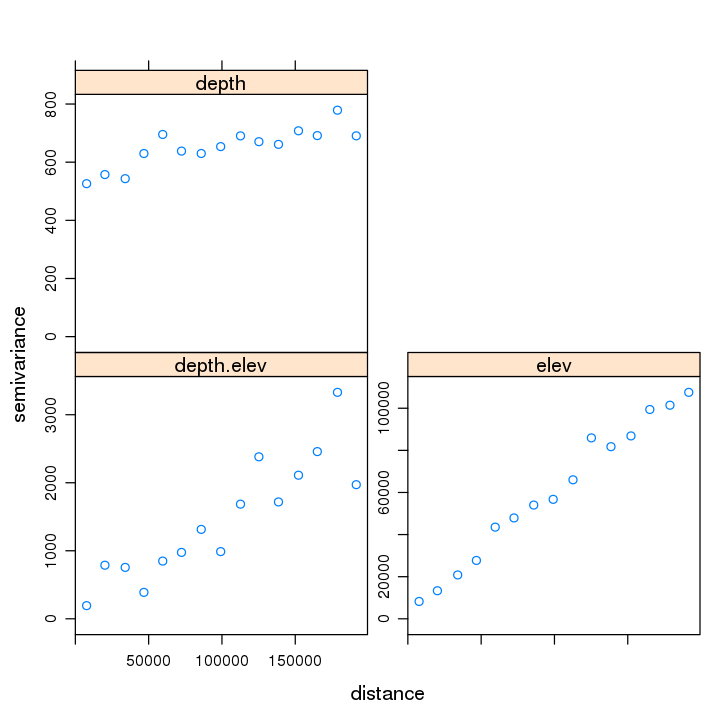

In [16]:
#empirical variogram
ck.vf.exp <- fit.lmc(ck.v,ck.g, vgm("Exp"))
ck.vf.exp

#plot the three variograms together
cc <- variogram(ck.vf.exp)
plot(cc)

If you wish to plot the fitted variograms separately for whatever reason, here is one way to accomplish that task.

model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Exp,272094.3,381159.9,0.5,0,0,0,1,1


model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Exp,614.8524,4009.945,0.5,0,0,0,1,1


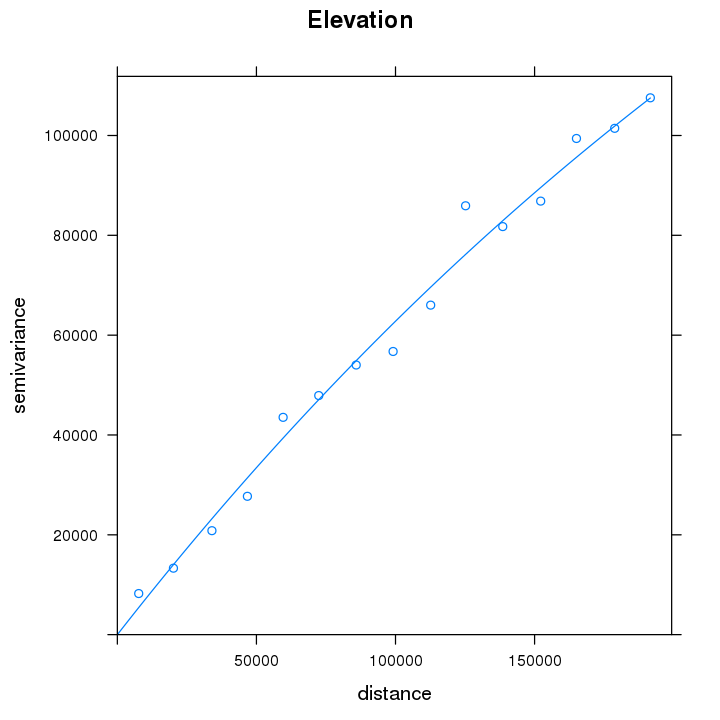

model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Exp,4388.018,232574.7,0.5,0,0,0,1,1


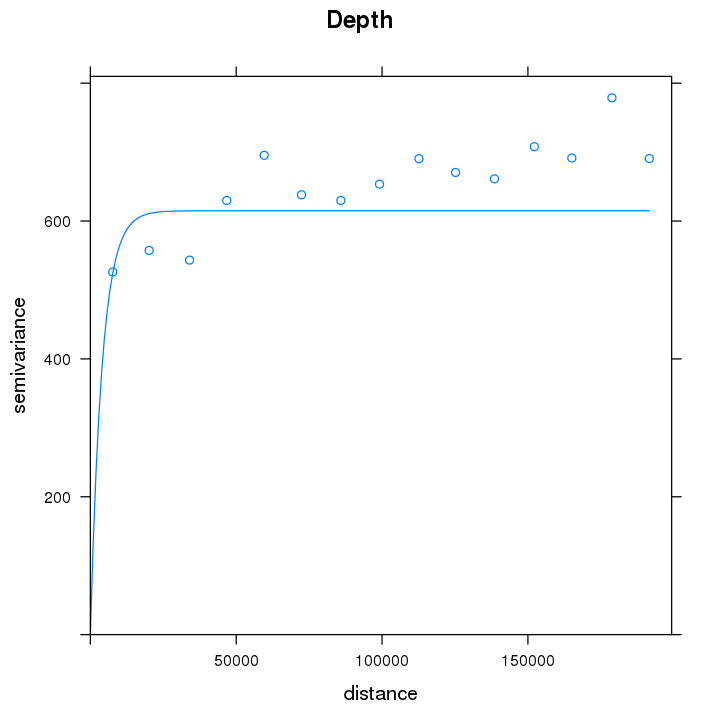

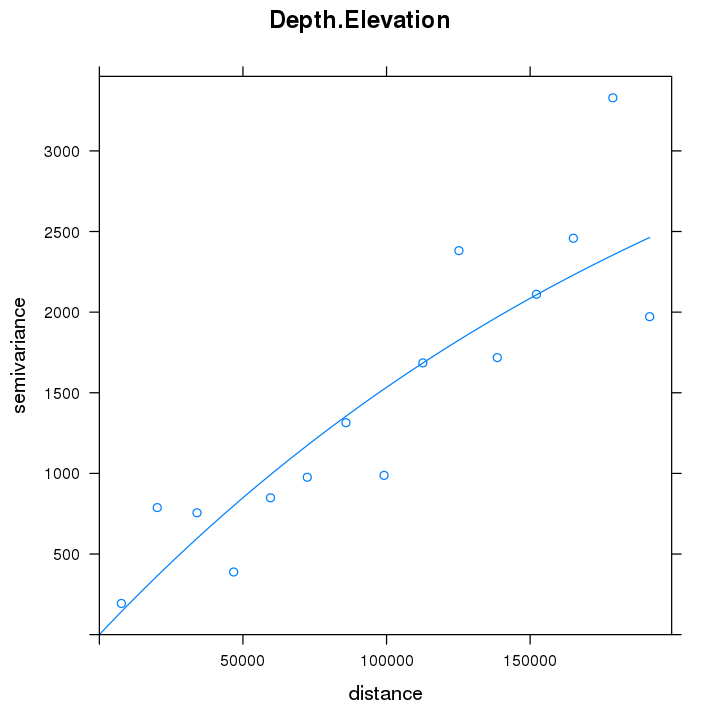

In [17]:
#plot the elevation vario
el <- fit.variogram(cc[cc$id=="elev",],vgm(model='Exp'))
el
plot(cc[cc$id=="elev",],el,main="Elevation",cex.main=.8)

#plot the depth vario
dp <- fit.variogram(cc[cc$id=="depth",],vgm(model='Exp'))
dp
plot(cc[cc$id=="depth",],dp,main="Depth",cex.main=.8)

#plot the depth.elevation vario
dpel <- fit.variogram(cc[cc$id=="depth.elev",],vgm(model='Exp'))
dpel
plot(cc[cc$id=="depth.elev",],dpel,main="Depth.Elevation",cex.main=.8)

## Interpolate using Co-Kriging

Interpolation using the co-kriging variables can be accomplished using the predict() function (gstat library) on the set of fitted variograms. The predict() function is similar to krige(), but is much more flexible. The interpolated results are stored in the grid created earlier.

In [18]:
#generate co-kriging results
ck.vf.exp$set <- list(nocheck=1)
ck.exp <- predict(ck.vf.exp, Reg.grid) 

Warning message in predict.gstat(ck.vf.exp, Reg.grid):
“No Intrinsic Correlation or Linear Model of Coregionalization found
Reason: ranges differ”

Now checking for Cauchy-Schwartz inequalities:
variogram(var0,var1) passed Cauchy-Schwartz
[using ordinary cokriging]


### Visualize the Interpolated Values

View the final results. Do they look reasonable? Remember, the depth values were transformed, so a backtransformation needs to be performed.  Note the variance increases dramatically in portions of the state having no well data ... lack of data == lack of interpolation!

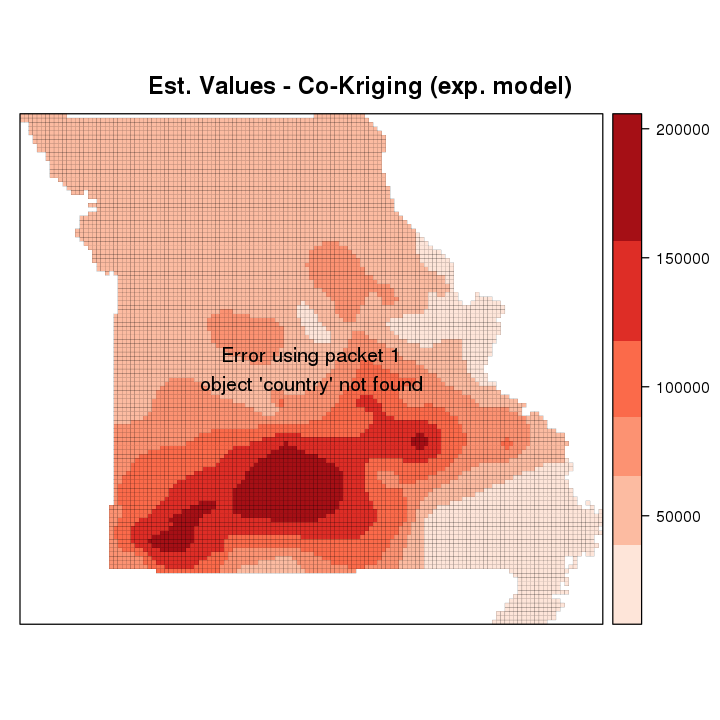

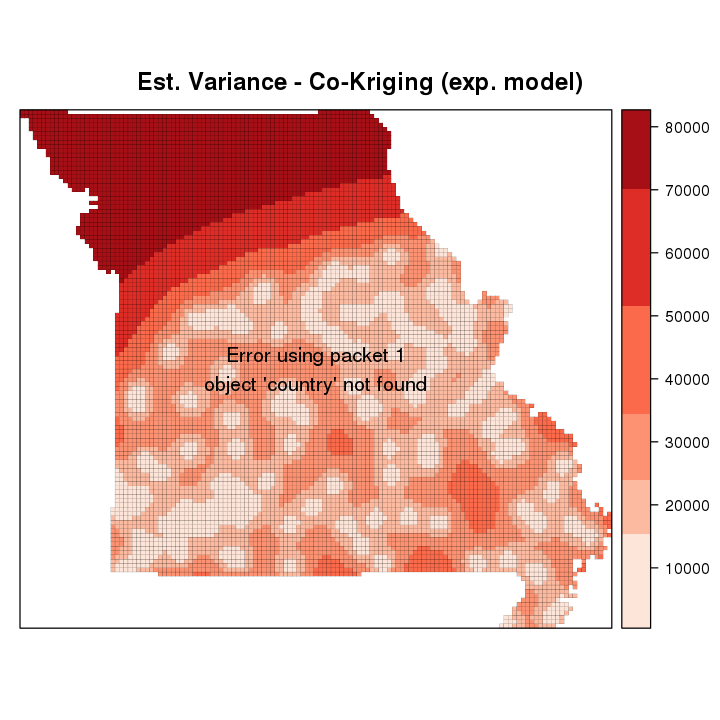

In [21]:
#backtransform predicted values
ck.exp@data$btvar.pred <- InvBoxCox(ck.exp@data$elev.pred, lambda)
btvals <- InvBoxCox(ck.exp@data$elev.pred, lambda)

#classify the predicted data values and assign a color schema
numcat <- 6
cate <- classIntervals(btvals, numcat, style = "kmeans")
color.pal <- brewer.pal(numcat,"Reds")

# Plot the Kriging estimation
spplot(ck.exp["btvar.pred"], col.regions = color.pal,
           main = "Est. Values - Co-Kriging (exp. model)",
           at = cate$brks, cex.main = 0.8,
           panel = function(...) {
               panel.gridplot(..., border="black")
               sp.polygons(country)
           })

#retrieve the variance from the gridded spatialpixels dataframe
varvals <- ck.exp@data$elev.var

#classify the variance and assign a color schema
numcat <- 6
cate2 <- classIntervals(varvals, numcat, style="kmeans")
color.pal2 <- brewer.pal(numcat,"Reds")

# Plot the variance of estimation
spplot(ck.exp["elev.var"], col.regions = color.pal2,
       at = cate2$brks, main = "Est. Variance - Co-Kriging (exp. model)", cex.main = 0.8,
           panel = function(...) {
                panel.gridplot(..., border="black")
                sp.polygons(country)
           })